In [243]:
from os import system, popen
import Xlib.display # python-xlib
import PIL.Image # python-imaging
import mss
import mss.tools
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import copy
from screen_utils import *

In [241]:
def kill_cows(fps, control_time, initial_wait=1.5, click_delay=5.0):
    time.sleep(initial_wait)
    
    window_coords = get_window_coords()
    width = window_coords[2] - window_coords[0]
    height = window_coords[3] - window_coords[1]
    window_center = (width // 2, height // 2)
    print(window_center)
    
    prev_time = time.time()
    click_timer = time.time() - click_delay

    for i in range(control_time * fps):
        window_pixels = grab_area(*window_coords)
        mask = get_cow_mask(window_pixels)
        bounding_boxes = get_bounding_boxes(mask)
        objects = tracker.add_frame(bounding_boxes)
        
        if time.time() - click_timer >= click_delay:
            click_timer = time.time()
            if objects:
                sorted_objects = list(sorted(objects, key=lambda k: dist(objects[k], window_center)))
                selected_obj = sorted_objects[len(sorted_objects)//2]
                obj_center = objects[selected_obj]
                click(obj_center[0], obj_center[1],window_offset=(window_coords[0], window_coords[1]))

        while time.time() - prev_time < 1./fps:
            time.sleep(0.001)

In [242]:
kill_cows(20, 120, initial_wait=1.5, click_delay=10.0)

(481, 350)
(715.5, 641.0)
(330.5, 693.5)
(777.5, 566.5)
(610.5, 675.5)
(719.5, 41.5)
(800.0, 49.0)
(610.5, 675.5)
(610.5, 675.5)
(98.5, 373.5)


In [164]:
def gen_cv_video(video_name, fps, video_len, initial_wait=1.5):
    time.sleep(initial_wait)
    
    window_coords = get_window_coords()
    width = window_coords[2] - window_coords[0]
    height = window_coords[3] - window_coords[1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_name + '.mp4', fourcc, fps, (width*2,height*2))
    prev_time = time.time()

    for _ in range(video_len * fps):
        window_pixels = grab_area(*window_coords)
        mask = get_cow_mask(window_pixels)
        bounding_boxes = get_bounding_boxes(mask)
        img_copy = copy.deepcopy(window_pixels)
        draw_boxes(img_copy, bounding_boxes)
        img_with_mask = cv2.bitwise_or(window_pixels, window_pixels, mask=mask)
        mask_img = mask_to_img(mask)

        row_1 = np.concatenate([window_pixels, mask_img], axis=0)
        row_2 = np.concatenate([img_with_mask, img_copy], axis=0)
        full_display = np.concatenate([row_1, row_2], axis=1)

        full_display = cv2.cvtColor(full_display, cv2.COLOR_RGB2BGR)
        video_writer.write(full_display)

        while time.time() - prev_time < 1./fps:
            time.sleep(0.001)

    video_writer.release()
    
def gen_cv_video_v2(video_name, fps, video_len, frame_skip, initial_wait=1.5):
    time.sleep(initial_wait)
    
    window_coords = get_window_coords()
    width = window_coords[2] - window_coords[0]
    height = window_coords[3] - window_coords[1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_name + '.mp4', fourcc, fps, (width*2,height*2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    tracker = ObjectTracker(300, 3000, time_threshold=fps//2, n_hist=fps)
    prev_time = time.time()

    for i in range(video_len * fps):
        window_pixels = grab_area(*window_coords)
        mask = get_cow_mask(window_pixels)
        mask_img = mask_to_img(mask)
        
        if i % frame_skip == 0:
            bounding_boxes = get_bounding_boxes(mask)
            objects = tracker.add_frame(bounding_boxes)
        
        img_copy_1 = copy.deepcopy(window_pixels)
        img_copy_2 = copy.deepcopy(window_pixels)
        
        for obj_id, center in objects.items():
            bottom_left = tuple(np.array(center, dtype=np.int32) + np.array([-10, 10]))
            cv2.putText(img_copy_2, 'id: ' + str(obj_id), bottom_left,
                        font, 0.7, (255, 0, 0), 2, cv2.LINE_AA)

        obj_centers = set(objects.values())
        select_boxes = []
        for bounding_box in bounding_boxes:
            if bounding_box[0] in obj_centers:
                select_boxes.append(bounding_box)

        draw_boxes(img_copy_1, bounding_boxes)
        draw_boxes(img_copy_2, select_boxes)

        column_1 = np.concatenate([window_pixels, img_copy_1], axis=0)
        column_2 = np.concatenate([mask_img, img_copy_2], axis=0)
        full_display = np.concatenate([column_1, column_2], axis=1)

        full_display = cv2.cvtColor(full_display, cv2.COLOR_RGB2BGR)
        video_writer.write(full_display)

        while time.time() - prev_time < 1./fps:
            time.sleep(0.001)

    video_writer.release()

In [165]:
FPS = 20
VIDEO_LEN = 5 # Seconds
FRAME_SKIP = 2
gen_cv_video_v2('tracking_test', FPS, VIDEO_LEN, FRAME_SKIP, initial_wait=1.5)

In [80]:
# FPS = 20
# VIDEO_LEN = 10 # Seconds
# gen_cv_video('test_2', 20, 10)

In [ ]:
# def dist(v1, v2):
#     return np.sqrt(np.sum((np.asarray(v1) - np.asarray(v2)) ** 2))

# def color_sim(target, others, threshold=10):
#     for other in others:
#         if dist(target, other) < threshold:
#             return True
#     return False

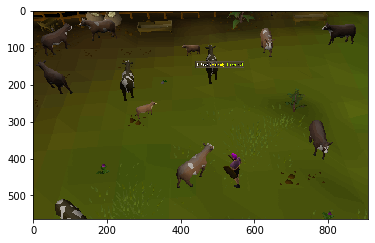

In [8]:
cow_img = cv2.imread('data/rs_cows.png')
cow_img = cv2.cvtColor(cow_img, cv2.COLOR_BGR2RGB)
plt.imshow(cow_img)

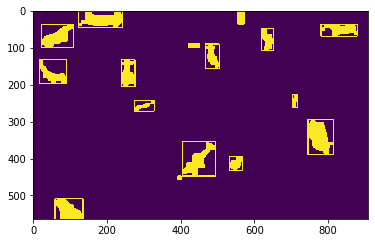

In [9]:
cow_mask = get_cow_mask(cow_img)

contours, _ = cv2.findContours(cow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

for bb in bounding_boxes:
    top_left = (bb[0], bb[1])
    bottom_right = (bb[0] + bb[2], bb[1] + bb[3])
    cv2.rectangle(cow_mask, top_left, bottom_right, (255, 255, 255), 2)

plt.imshow(cow_mask)

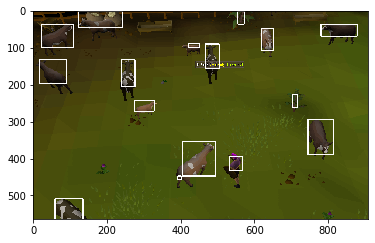

In [23]:
for bb in bounding_boxes:
    top_left = (bb[0], bb[1])
    bottom_right = (bb[0] + bb[2], bb[1] + bb[3])
    cv2.rectangle(cow_img, top_left, bottom_right, (255, 255, 255), 2)
    
plt.imshow(cow_img)

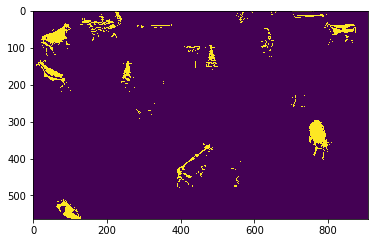

In [87]:
plt.imshow(mask)

In [311]:
hsv_white_range = [(0,  0, 99), (29, 52, 255)]
hsv_brown_range = [(0, 93, 23), (175, 119,  133)]

hsv_cow_img = cv2.cvtColor(cow_img, cv2.COLOR_RGB2HSV)
brown_mask = cv2.inRange(hsv_cow_img, hsv_brown_range[0], hsv_brown_range[1])
white_mask = cv2.inRange(hsv_cow_img, hsv_white_range[0], hsv_white_range[1])
mask = brown_mask | white_mask

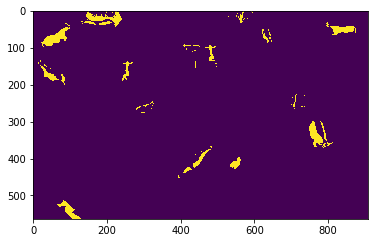

In [308]:
plt.imshow(brown_mask)

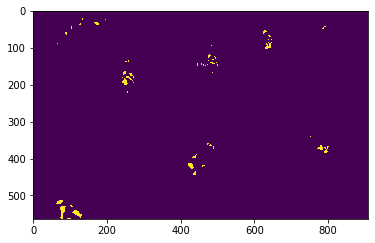

In [309]:
plt.imshow(white_mask)

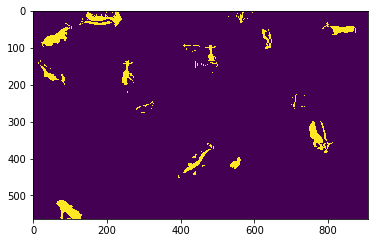

In [310]:
plt.imshow(mask)

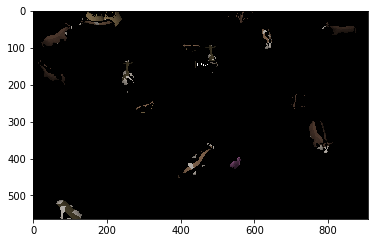

In [285]:
plt.imshow(cv2.bitwise_and(cow_img, cow_img, mask=mask))

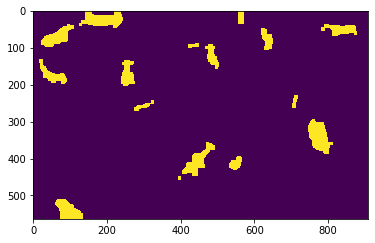

In [447]:
kernel = np.ones((3, 3), np.uint8)
eroded_mask = cv2.erode(mask, kernel, iterations=1)
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=2)
closed_mask = cv2.morphologyEx(dilated_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
final_mask = closed_mask
plt.imshow(final_mask)

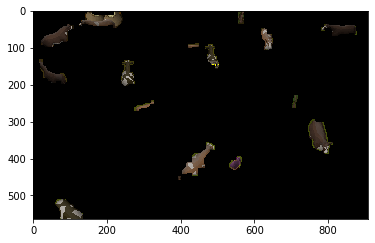

In [439]:
plt.imshow(cv2.bitwise_and(cow_img, cow_img, mask=final_mask))